In [1]:
from typing import Dict, Tuple

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import torch

import src.networks.residualrmn as residualrmn
import src.networks.init_utils as init_utils

# auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

# Eigenspectrum Analysis

In this notebook, we provide a small tutorial to replicate the eigenspectrum analyses in our paper *Residual Reservoir Memory Networks*, IJCNN (2025). Specifically, the tutorial covers the following:
- **Eigenspectrum analysis of the orthogonal matrices** employed in the temporal residual connections (Figure 2);
- **Eigenspectrum analysis of the Jacobian** of each ResRMN configuration (Figure 3).

## Orthogonal matrices

Here, we visualize the eigenvalues distribution of the three orthogonal matrices (random orthogonal, cyclic orthogonal, and identity) employed to initialize the temporal residual connections.

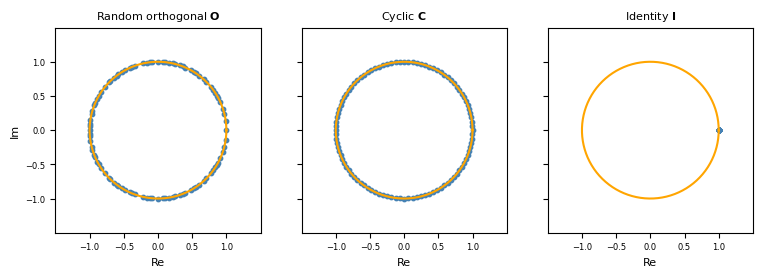

In [3]:
Nh = 100 # assuming 100 recurrent neurons as in the manuscript
ortho_configs = {
    'ortho': r'Random orthogonal $\mathbf{O}$',
    'cycle': r'Cyclic $\mathbf{C}$', 
    'identity': r'Identity $\mathbf{I}$'
}

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True)
for idx, (ortho_config, title) in enumerate(ortho_configs.items()):
    ax = axes[idx]
    ax.set_aspect('equal')

    # Eigenvalues
    O = init_utils.init_orthogonal(
        M=Nh,
        ortho_config=ortho_config
    )
    eig = torch.linalg.eig(O)[0]
    ax.scatter(eig.real, eig.imag, c='steelblue', marker='o', s=10)
    
    # Unitary circle
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='orange')

    # Labels
    ax.set_title(title)
    ax.set_xlabel('Re')
    axes[0].set_ylabel('Im', rotation='vertical')
    
    # Limits and axes
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax.set_yticks([-1., -0.5, 0., 0.5, 1.])

plt.show()

## Jacobian of ResRMN

Here, we visualize the eigenvalues distribution of the Jacobian for all three ResRMN configurations: ResRMN$_\mathrm{R}$, ResRMN$_\mathrm{C}$, ResRMN$_\mathrm{I}$.

The dynamics of ResRMN are driven by a random input vector and a random state, both uniformly sampled in $(-1, 1)$. We assume the same hyperparameters mentioned in the manuscripts. 
Specifically, $N_{m}, N_{h} = 100$ recurrent neurons in both modules, spectral radius $\rho = 1$, all input weight matrices with scaling of $1$, zero bias $\omega_{b} = 0$, and scaling coefficients $\alpha = 1$, $\beta = 1$. 
However, feel free to play around with them.

In [4]:
def get_jacobian_eigenvalues(hparams: Dict, resrmn_config: str) -> Tuple[torch.Tensor, torch.Tensor]:
    """Initialize a ResRMN and compute its Jacobian's eigenspectrum.
    
    This utility method initializes a specific ResRMN configuration, drives its dynamics with a 
    random external input and a random state, both uniformly sampled in (-1, 1), and computes the 
    eigenspectrum of the Jacobian of the memory and non-linear module. 
    Note that the eigenvalues of a ResRMN's Jacobian are non-other than the union of the 
    eigenvalues of the Jacobian of the memory module (i.e., matrix V_m) and the Jacobian of the 
    non-linear module.

    Args:
        hparams: Hyperparameters dictionary.
        resrmn_config: The configuration to employ in the temporal residual connections. Options 
        are 'ortho', 'cycle', and 'identity'.

    Returns:
        eig_m: The eigenvalues of the Jacobian of the memory module.
        eig: The eigenvalues of the Jacobian of the non-linear module.
    """
    model = residualrmn.residualrmn_(hparams=hparams, skip_option_t=resrmn_config)

    # External input and states
    x = torch.FloatTensor(hparams['in_size']).uniform_(-1, 1)
    m_prev = torch.FloatTensor(hparams['n_units_m']).uniform_(-1, 1)
    h_prev = torch.FloatTensor(hparams['n_units']).uniform_(-1, 1)
    
    # Memory module eigenvalues
    Vm = model.memory_reservoir.cell.recurrent_memory_kernel # Jacobian
    mt = m_prev @ model.memory_reservoir.cell.recurrent_memory_kernel + x @ model.memory_reservoir.cell.in_kernel # forward pass
    eig_m = torch.linalg.eig(Vm)[0] # eigenvalues
    
    # Non-linear module eigenvalues
    pt = h_prev @ model.nonlinear_reservoir.cell.recurrent_kernel + mt @ model.nonlinear_reservoir.cell.memory_kernel + x @ model.nonlinear_reservoir.cell.in_kernel + model.nonlinear_reservoir.cell.bias # intermediate activation
    D = torch.diag(1 - torch.tanh(pt)**2)
    J = (hparams['alpha'] * model.nonlinear_reservoir.cell.O) + (hparams['beta'] * D @ model.nonlinear_reservoir.cell.recurrent_kernel) # Jacobian
    eig = torch.linalg.eig(J)[0] # eigenvalues
    
    return eig_m, eig

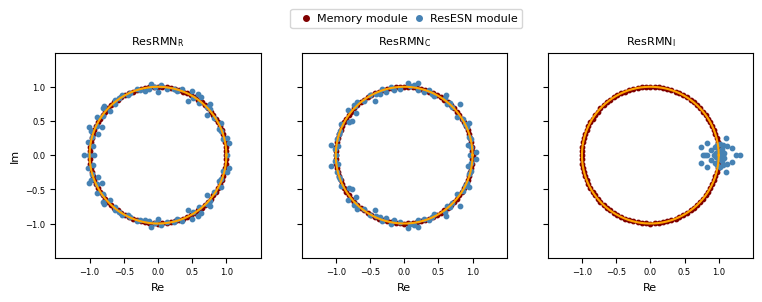

In [6]:
# Hyperparameters
hparams = {
    'in_size': 1, # input size (N_x)
    'n_units_m': 100, # memory reservoir recurrent neurons (N_m)
    'n_units': 100, # non-linear reservoir recurrent neurons (N_h)
    'rho': 1., # spectral radius (\rho)
    'alpha': 1., # residual branch coefficient
    'beta': 1. # non-linear branch coefficient
}
resrmn_configs = {
    'ortho': r'ResRMN$_\mathrm{R}$',
    'cycle': r'ResRMN$_\mathrm{C}$', 
    'identity': r'ResRMN$_\mathrm{I}$'
}

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True, sharex=True)
for idx, (resrmn_config, title) in enumerate(resrmn_configs.items()):
    ax = axes[idx]
    ax.set_aspect('equal')

    # Get eigenvalues of the Jacobian of each module
    eig_m, eig = get_jacobian_eigenvalues(hparams=hparams, resrmn_config=resrmn_config)
    ax.scatter(eig_m.real, eig_m.imag, c='maroon', marker='o', s=10)
    ax.scatter(eig.real, eig.imag, c='steelblue', marker='o', s=10)
    
    # Unitary circle
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='orange')

    # Labels
    ax.set_title(title)
    ax.set_xlabel('Re')
    axes[0].set_ylabel('Im', rotation='vertical')
    
    # Limits and axes
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xticks([-1., -0.5, 0., 0.5, 1.])
    ax.set_yticks([-1., -0.5, 0., 0.5, 1.])

fig.legend(
    handles=[
        mlines.Line2D([], [], color='maroon', marker='o', linestyle='None', markersize=4, label='Memory module'),
        mlines.Line2D([], [], color='steelblue', marker='o', linestyle='None',  markersize=4, label='ResESN module')
    ],
    bbox_to_anchor=(0.515, 1.), 
    loc='upper center', 
    ncol=2, 
    handletextpad=0, 
    columnspacing=0
)
plt.show()